1. Inicialização de bibliotecas

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import wavfile
from dataclasses import dataclass
plt.rcParams['figure.dpi'] = 100

2. Métodos geradores de funções

In [69]:
from abc import abstractmethod

class LowPassFilter:
    def __init__(self, a0, a1, a2, b1, b2) -> None:
        self.in_z1, self.in_z2, self.out_z1, self.out_z2 = 0, 0, 0, 0
        self.a0, self.a1, self.a2, self.b1, self.b2 = a0, a1, a2, b1, b2

    def process(self, in_sample):
        out_sample = (
              self.a0 * in_sample
            + self.a1 * self.in_z1
            + self.a2 * self.in_z2
            - self.b1 * self.out_z1
            - self.b2 * self.out_z2 
        )

        self.in_z2 = self.in_z1
        self.in_z1 = in_sample

        self.out_z2 = self.out_z1
        self.out_z1 = out_sample

        return out_sample

    def apply (self, wave):
        return [self.process(sample) for sample in wave]

def wave_plot(time, amplitude, frequency):
    plt.plot(time, amplitude)
    plt.axis((0, 5 / frequency, -1.1, 1.1))
    plt.xlabel('tempo (segundos)')
    plt.ylabel('amplitude (u.a.)')

class Wave:
    def __init__(self, seconds, sample_rate, frequency, file = None) -> None:
        self.seconds = seconds
        self.sample_rate = sample_rate
        self.frequency = frequency
        self.gen_wave(file)

    @abstractmethod
    def gen_wave(self, file):
        pass
    
    def plot (self):
        wave_plot(self.time, self.amplitude, self.frequency)

    def fft (self):
        sample_count = (self.sample_rate * self.seconds)
        x_fft = fftfreq(sample_count, 1 / self.sample_rate)
        y_fft = fft(self.amplitude) / sample_count
        return x_fft, y_fft

    def fft_plot (self):
        x_fft, y_fft = self.fft()
        plt.plot(x_fft, np.abs(y_fft))
        plt.axis((0, self.sample_rate / 2, 0, max(abs(y_fft))* 2))
        plt.xlabel('frequência (hertz)')
        plt.ylabel('amplitude (u.a.)');
        plt.show()

    def apply_filter(self, filter: LowPassFilter):
        self.amplitude = filter.apply(self.amplitude)

class SquareWave(Wave):
    def gen_wave(self, file = None):
        self.time        = np.linspace(0, self.seconds, self.sample_rate * self.seconds)
        self.amplitude   = signal.square(2 * np.pi * self.frequency * self.time)

class SineWave(Wave):
    def gen_wave(self, file = None):
        self.time = np.linspace(0, self.seconds, self.sample_rate * self.seconds)
        self.amplitude = np.sin(2 * np.pi * self.frequency * self.time)

class RealWave(Wave):
    def gen_wave(self, file):
        file_sample_rate, file_data = wavfile.read(file)
        self.sample_rate = file_sample_rate
        self.time = np.linspace(0, self.seconds, self.sample_rate * self.seconds)
        self.max_amplitude = max(file_data)
        self.amplitude = file_data / self.max_amplitude

    def output(self, file_name = 'output.wav'):
        # original_amplitude = self.amplitude * self.max_amplitude
        np_amplitude = np.array(self.amplitude)
        wavfile.write(file_name, self.sample_rate, np_amplitude)
    



3. Geração e plot de onda quadrada inicial

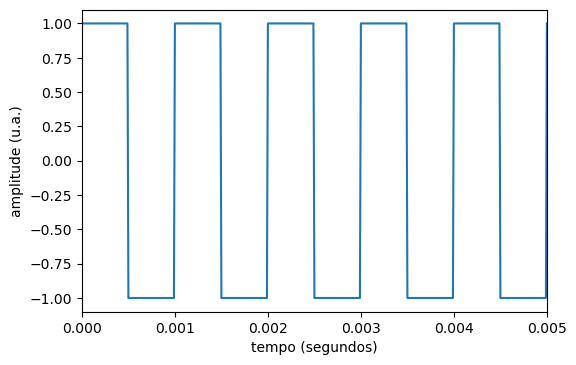

In [70]:
square_wave = SquareWave(50, 96000, 1000)
square_wave.plot()

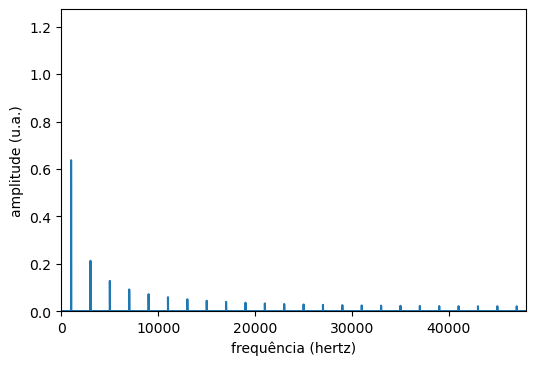

In [71]:
square_wave.fft_plot()

4. Geração e plot de onda senoidal inicial

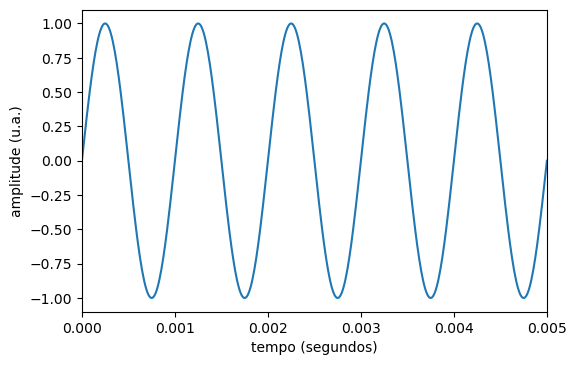

In [72]:
sine_wave = SineWave(50, 96000, 1000)
sine_wave.plot()

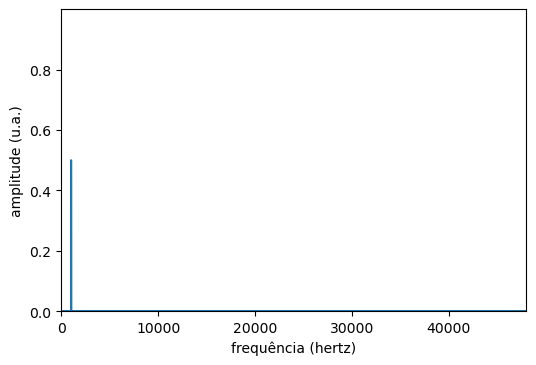

In [73]:
sine_wave.fft_plot()

Implementação do Filtro

In [74]:
from copy import deepcopy


low_pass_filter = LowPassFilter(
     0.011050373933114971,
     0.022100747866229942,
     0.011050373933114971,
    -1.3368583644305965,
     0.3810598601630564
)

Aplicação do filtro em onda quadrada

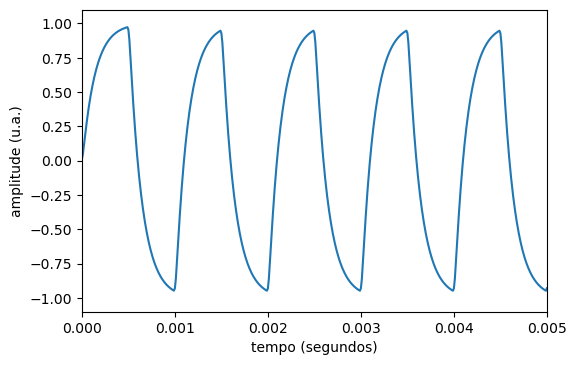

In [75]:

filtered_square_wave = deepcopy(square_wave)
filtered_square_wave.apply_filter(low_pass_filter)
filtered_square_wave.plot()



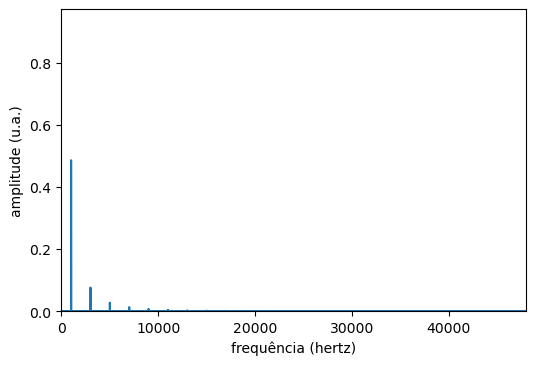

In [76]:
filtered_square_wave.fft_plot()

Aplicação de filtro em onda real (música)

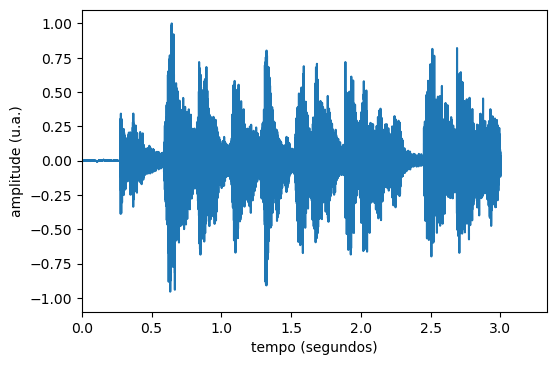

In [77]:
real_wave = RealWave(3, 0, 1.5, './CantinaBand3.wav')
real_wave.plot()

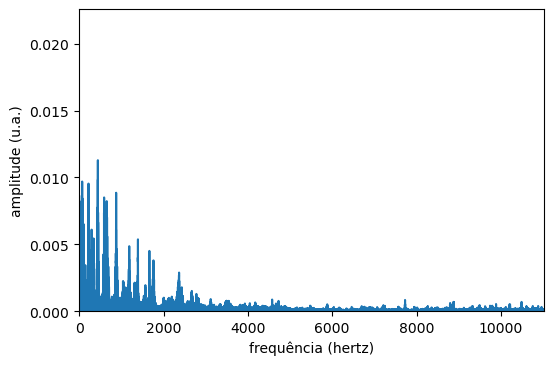

In [78]:
real_wave.fft_plot()

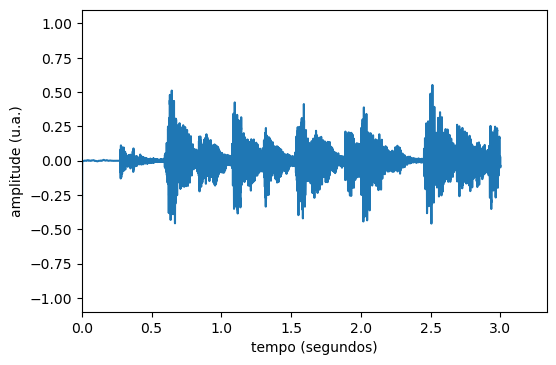

In [79]:
filtered_real_wave = deepcopy(real_wave)
filtered_real_wave.apply_filter(low_pass_filter)
filtered_real_wave.plot()

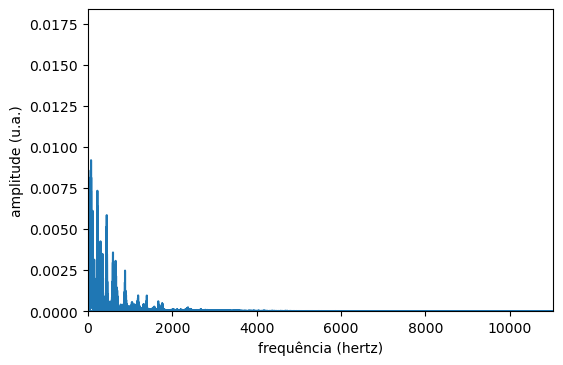

In [80]:
filtered_real_wave.fft_plot()

In [81]:
filtered_real_wave.output()